In [1]:
# Load library
import sys
import sklearn

import pickle
import numpy as np
import pandas as pd
import cv2
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import csv

print(sys.version)
print('The numpy version is {}.'.format(np.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
The numpy version is 1.19.2.
The pandas version is 1.1.3.
The scikit-learn version is 0.23.2.


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [212]:
# Load images from otomatch data
path = '/Users/phunp/Documents/Flinders/Thesis/data/otomatch/Tube_Effusion_Normal-11_7_19/All/'
label_path = '/Users/phunp/Documents/Flinders/Thesis/data/otomatch/Tube_Effusion_Normal-11_7_19/labels-with-augmented.csv'

WIDTH = 200
HEIGHT = 228
SIZE = WIDTH * HEIGHT * 3
IMAGE_COUNT = 537

LABEL_CONVERTER = {"Normal": 0, "Effusion": 1, "Tube": 2}

indexes = {}

def load_images_from_folder(folder):
    images = np.empty((IMAGE_COUNT, SIZE)) #==> FOR NORMAL
    i = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            # plt.imshow(img)
            # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            
            # resize image to a fix size
            img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
            flatten = img.reshape(-1) # ==> FOR NORMAL MODEL
            # flatten = img # FOR MOBILEV2 NET
            
            images[i] = flatten
            indexes[filename] = i
            i+=1
            setSize.add(img.shape)

    return images

# Load all images into X
X = load_images_from_folder(path)
print('X shape: ', X.shape)

# avgRatio = sum([(x.shape[0]/x.shape[1]) for x in X]) / len(X)
# avgX = sum([(x.shape[0]) for x in X]) / len(X)
# avgY = sum([(x.shape[1]) for x in X]) / len(X)
# print('avgRatio: {}, avgX {}, avgY {}'.format(avgRatio, avgX, avgY))
# avgRatio: 0.8751151786261735, avgX 880.784140969163, avgY 1033.7863436123348
# selected: size of 200 x 228

# Load all labels into Y
label = {}
with open(label_path, mode='r', encoding='utf-8-sig') as csv_labels:
    csv_reader = csv.DictReader(csv_labels)
    # next(csv_reader)
    for row in csv_reader:
        # print(dict(row))
        # print(row['Image_Name'])
        # csv format: [ImageName, Label]
        label[row["Image_Name"]] = LABEL_CONVERTER[row['Label']]
        # Map string label to integer
        if (LABEL_CONVERTER[row['Label']] not in {0,1,2}):
            print('something wrong with the image: ', row["Image_Name"])

            
# Map y to X by index
y = np.empty([IMAGE_COUNT], dtype=int)
for key in indexes:
    y[int(indexes[key])] = int(label[key])


# TRY TO RESTORE THINGS - Just test
# print(type(X[0]))
# restoreImg = np.copy(X[0])
# restoreImg = restoreImg.reshape(HEIGHT, WIDTH, 3)
# print(type(restoreImg))
# plt.imshow(restoreImg)


X shape:  (537, 136800)


In [140]:
# ensure number of samples in each category
from collections import Counter
Counter(y)
# 179 normal, 179 effusion, 179 tube Total 537

Counter({2: 179, 0: 179, 1: 179})

shape of data {} (355, 441, 3)


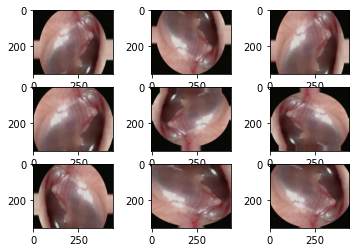

In [85]:
# Augmentation sample for one image

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import cv2

# load the image
img = cv2.imread("/Users/phunp/Documents/Flinders/Thesis/data/otomatch/Tube_Effusion_Normal-11_7_19/test-read/AM1L.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# pyplot.subplot(0)
# pylot.imshow(img)
# convert to numpy array
data = img_to_array(img)
print("shape of data {}", data.shape)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(zoom_range=[0.8,1.2], horizontal_flip=True, vertical_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    cv2.imwrite("/Users/phunp/Documents/Flinders/Thesis/data/otomatch/Tube_Effusion_Normal-11_7_19/test-read/aug-" + str(i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [86]:
# Prepare the augmentation images for tubes image beforehand

TUBE_ORI_FILE_PATH = "/Users/phunp/Documents/Flinders/Thesis/data/otomatch/Tube_Effusion_Normal-11_7_19/Tube/"
TUBE_AUGMENTED_FILE_PATH = "/Users/phunp/Documents/Flinders/Thesis/data/otomatch/Tube_Effusion_Normal-11_7_19/Tube-Augmented/"

NUM_ORI_TUBE = 96
NUM_TARGET = 179

datagen = ImageDataGenerator(zoom_range=[0.8,1.2], horizontal_flip=True, vertical_flip=True)

i = 1

for filename in os.listdir(TUBE_ORI_FILE_PATH):
    if i > (NUM_TARGET - NUM_ORI_TUBE):
        break;
    img = cv2.imread(os.path.join(TUBE_ORI_FILE_PATH, filename))
    if img is not None:
        # convert to numpy array
        data = img_to_array(img)
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        cv2.imwrite(TUBE_AUGMENTED_FILE_PATH + "Tube-aug-" + str(i) + ".jpg", image)
        i += 1

print("generated %d at path %s" % (i - 1, TUBE_AUGMENTED_FILE_PATH))

generated 83 at path /Users/phunp/Documents/Flinders/Thesis/data/otomatch/Tube_Effusion_Normal-11_7_19/Tube-Augmented/


In [93]:
print(X.shape)
print(y.shape)

(537, 136800)
(537,)


In [141]:
# SVC model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

X1 = X[0:537]
y1 = y[0:537]

# split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)

# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

# do the PCA, choose the numbher of components to retain
input_pca = PCA(n_components=100)
input_pca.fit(Xtrain_std)
Xtrain_std_pca = input_pca.transform(Xtrain_std)
Xtest_std_pca = input_pca.transform(Xtest_std)

C = 10
model = SVC(kernel='rbf', C=C)
model.fit(Xtrain_std_pca, ytrain)

print("-----------------")
print("Training performance: ")
y_pred_train = model.predict(Xtrain_std_pca)
report_train = classification_report(ytrain, y_pred_train)
print(report_train)

print("-----------------")
print("Validation performance: ")
y_pred = model.predict(Xtest_std_pca)
report_val = classification_report(ytest, y_pred)
print(report_val)

-----------------
Training performance: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       125
           1       0.99      0.97      0.98       125
           2       1.00      0.99      1.00       125

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375

-----------------
Validation performance: 
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        54
           1       0.82      0.67      0.73        54
           2       0.85      0.87      0.86        54

    accuracy                           0.83       162
   macro avg       0.83      0.83      0.82       162
weighted avg       0.83      0.83      0.82       162



In [142]:
print("Training matthews_corrcoef")
matthews_corrcoef(ytrain, y_pred_train)

Training matthews_corrcoef


0.9801359216056807

In [143]:
print("Validation matthews_corrcoef")
matthews_corrcoef(ytest, y_pred)

Validation matthews_corrcoef


0.744623794358824

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        54
           1       0.82      0.67      0.73        54
           2       0.85      0.87      0.86        54

    accuracy                           0.83       162
   macro avg       0.83      0.83      0.82       162
weighted avg       0.83      0.83      0.82       162



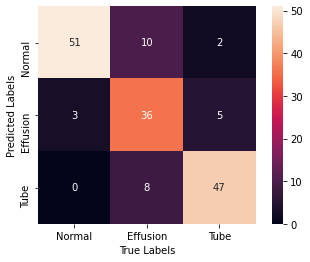

In [144]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_labels = ["Normal", "Effusion", "Tube"]

print(report_val)
mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [114]:
# Grid search for hyperparameter tuning SVM
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
std = StandardScaler()
pca = PCA(n_components=50)
svc = SVC(kernel='rbf')
pipe_svc = Pipeline([('std',std),('pca', pca),('svc',svc)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_svc = {
    'pca__n_components': [10, 50, 100],
    'svc__kernel': ['rbf', 'linear', 'sigmoid'],
    'svc__C': [0.1, 1, 10],
    #'svc__gamma' : np.logspace(-9, 9, num=20, base=10)
}

search_svc = GridSearchCV(pipe_svc, param_grid_svc,
                      scoring="accuracy",
                      #cv=StratifiedKFold(n_splits=2),
                      cv=5, # default to stratified
                      verbose=3, 
                      #n_jobs=3, enable n_jobs did not give any logs. I want logs
                         )
%time search_svc.fit(Xtrain, ytrain)
print("Best parameter (CV score=%0.3f):" % search_svc.best_score_)
print(search_svc.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=rbf ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=rbf, score=0.560, total=   2.8s
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=rbf ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=rbf, score=0.613, total=   3.1s
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=rbf ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=rbf, score=0.667, total=   2.8s
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=rbf ...............
[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=rbf, score=0.467, total=   2.8s
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=rbf ...............
[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=rbf, score=0.507, total=   2.7s
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=linear ............
[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=linear, score=0.560, total=   5.2s
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=linear ............
[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=linear, score=0.560, total=   4.5s
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=linear ............
[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=linear, score=0.453, total=   4.6s
[CV] pca__n_components=10, svc__C=0.1, svc__kernel=linear ............
[CV]  pca__n_components=10, svc__C=0.1, svc__kernel=linear, s

[CV]  pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid, score=0.480, total=   3.1s
[CV] pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid ...........
[CV]  pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid, score=0.453, total=   3.1s
[CV] pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid ...........
[CV]  pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid, score=0.307, total=   3.1s
[CV] pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid ...........
[CV]  pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid, score=0.373, total=   3.1s
[CV] pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid ...........
[CV]  pca__n_components=50, svc__C=0.1, svc__kernel=sigmoid, score=0.520, total=   3.1s
[CV] pca__n_components=50, svc__C=1, svc__kernel=rbf .................
[CV]  pca__n_components=50, svc__C=1, svc__kernel=rbf, score=0.627, total=   3.0s
[CV] pca__n_components=50, svc__C=1, svc__kernel=rbf .................
[CV]  pca__n_components=50, svc__C=1, svc__kernel=rb

[CV]  pca__n_components=100, svc__C=1, svc__kernel=rbf, score=0.613, total=   4.3s
[CV] pca__n_components=100, svc__C=1, svc__kernel=rbf ................
[CV]  pca__n_components=100, svc__C=1, svc__kernel=rbf, score=0.733, total=   4.9s
[CV] pca__n_components=100, svc__C=1, svc__kernel=linear .............
[CV]  pca__n_components=100, svc__C=1, svc__kernel=linear, score=0.587, total=   4.6s
[CV] pca__n_components=100, svc__C=1, svc__kernel=linear .............
[CV]  pca__n_components=100, svc__C=1, svc__kernel=linear, score=0.533, total=   4.5s
[CV] pca__n_components=100, svc__C=1, svc__kernel=linear .............
[CV]  pca__n_components=100, svc__C=1, svc__kernel=linear, score=0.573, total=   4.4s
[CV] pca__n_components=100, svc__C=1, svc__kernel=linear .............
[CV]  pca__n_components=100, svc__C=1, svc__kernel=linear, score=0.533, total=   4.4s
[CV] pca__n_components=100, svc__C=1, svc__kernel=linear .............
[CV]  pca__n_components=100, svc__C=1, svc__kernel=linear, score

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 71.0min finished


CPU times: user 1h 20min 47s, sys: 1min 52s, total: 1h 22min 39s
Wall time: 1h 11min 4s
Best parameter (CV score=0.749):
{'pca__n_components': 100, 'svc__C': 10, 'svc__kernel': 'rbf'}


Pipeline(steps=[('std', StandardScaler()), ('pca', PCA(n_components=100)),
                ('svc', SVC(C=10))])
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        54
           1       0.82      0.67      0.73        54
           2       0.85      0.87      0.86        54

    accuracy                           0.83       162
   macro avg       0.83      0.83      0.82       162
weighted avg       0.83      0.83      0.82       162



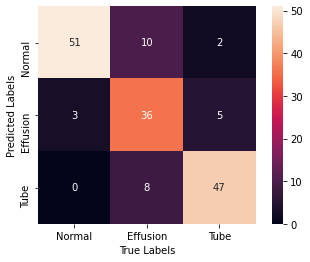

In [115]:
best_model_svc = search_svc.best_estimator_
yfit = best_model_svc.predict(Xtest)
print(best_model_svc)

class_labels = ["Normal", "Effusion", "Tube"]

print(classification_report(ytest,yfit))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [120]:
def calculate_bm(cm):

    TN = cm[1][1]
    FN = cm[0][1]
    TP = cm[0][0]
    FP = cm[1][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    F1 = 2*(PPV*TPR)/(PPV+TPR)
    BM = TPR + TNR - 1

    return BM


Evaluation of hidden_layer_size: 500, max_iter: 1000

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        54
           1       0.75      0.67      0.71        54
           2       0.81      0.80      0.80        54

    accuracy                           0.78       162
   macro avg       0.78      0.78      0.78       162
weighted avg       0.78      0.78      0.78       162

Bookmaker for MLP model is 0.69
Validation matthews_corrcoef


0.6683112015731824

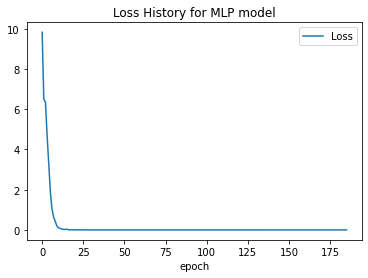

In [151]:
# MLP Model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier

X1 = X[0:537]
y1 = y[0:537]

# split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1,test_size=0.3, random_state=42, stratify=y1)

# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

# do the PCA, choose the numbher of components to retain
input_pca = PCA(n_components=100)
input_pca.fit(Xtrain_std)
Xtrain_std_pca = input_pca.transform(Xtrain_std)
Xtest_std_pca = input_pca.transform(Xtest_std)

## MLP PART
data_name = "MLP model"
# model initialization
hidden_layer_size = 500
max_iter = 1000
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_size), max_iter=max_iter, alpha=0.0001, #try change hidden layer, or max_iter
                    solver='sgd', verbose=0, tol=0.000001, #try verbode=0 to train with out logging
                    early_stopping=False, momentum=0.9) # lbfgs

### Train the Model
# The function call to `fit` trains the model using the training data.  
h = mlp.fit(Xtrain_std_pca, ytrain)

### Plot a loss curve
# The loss curve shows the history of how the training progressed.
plt.plot(h.loss_curve_)
plt.title('Loss History for ' + data_name)
plt.xlabel('epoch')
plt.legend(['Loss'])


## Evaluate the performance of the classifier
# Let's have a look at predicting the first 10 instances in the test data set.  How did it do?  How many matches?
# print('predictions: {0}'.format(mlp.predict(Xtest_std_pca[0:10,:])))
# print('acutal     : {0}'.format(np.ravel(ytest)[0:10]))

# Calculate evaluation measures
print()
print('Evaluation of hidden_layer_size: {}, max_iter: {}'.format(hidden_layer_size, max_iter))
print()
y_pred = mlp.predict(Xtest_std_pca)
cm = confusion_matrix(ytest, y_pred,normalize=None)
cr = classification_report(ytest,y_pred)
print(cr)
f1 = f1_score(ytest, y_pred,average='weighted')
cm = confusion_matrix(ytest, y_pred)
bm = calculate_bm(cm)
print('Bookmaker for {0} is {1:.2f}'.format(data_name,bm))
print("Validation matthews_corrcoef")
matthews_corrcoef(ytest, y_pred)

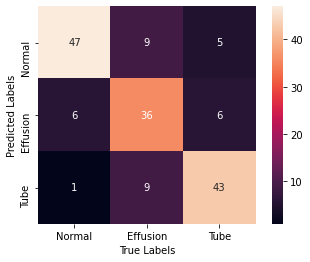

In [152]:
# Confusion matrix for mlp
mat = confusion_matrix(ytest, y_pred)

class_labels = ["Normal", "Effusion", "Tube"]

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [135]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
std = StandardScaler()
pca = PCA(n_components=100)
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_size), max_iter=max_iter, alpha=0.001, #try change hidden layer, or max_iter
                    solver='sgd', verbose=0, tol=0.000001, #try verbode=0 to train with out logging
                    early_stopping=False, momentum=0.9)
pipe_mlp = Pipeline([('std',std),('pca', pca),('mlp',mlp)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_mlp = {
    'pca__n_components': [10, 50, 100],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__max_iter': [500, 1000],
    'mlp__hidden_layer_sizes': [(100), (250), (500)],
#   'svc__gamma' : np.logspace(-9, 9, num=2, base=10)
}


search_mlp = GridSearchCV(pipe_mlp, param_grid_mlp,
                      scoring="accuracy",
                      #cv=StratifiedKFold(n_splits=2),
                      cv=5,
                      verbose=3, 
                      n_jobs=3,
                         )
%time search_mlp.fit(Xtrain, ytrain)
print("Best parameter (CV score=%0.3f):" % search_mlp.best_score_)
print(search_mlp.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:  6.7min finished


CPU times: user 14.4 s, sys: 1.2 s, total: 15.6 s
Wall time: 6min 47s
Best parameter (CV score=0.659):
{'mlp__hidden_layer_sizes': 500, 'mlp__max_iter': 1000, 'mlp__solver': 'sgd', 'pca__n_components': 100}


Pipeline(steps=[('std', StandardScaler()), ('pca', PCA(n_components=100)),
                ('mlp',
                 MLPClassifier(alpha=0.001, hidden_layer_sizes=500,
                               max_iter=1000, solver='sgd', tol=1e-06,
                               verbose=0))])
              precision    recall  f1-score   support

           0       0.75      0.81      0.78        54
           1       0.74      0.59      0.66        54
           2       0.73      0.81      0.77        54

    accuracy                           0.74       162
   macro avg       0.74      0.74      0.74       162
weighted avg       0.74      0.74      0.74       162



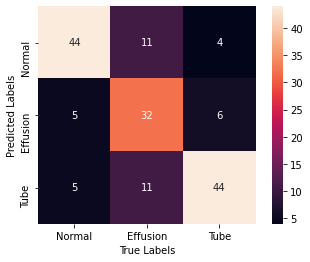

In [136]:
best_model_mlp = search_mlp.best_estimator_
yfit = best_model_mlp.predict(Xtest)
print(best_model_mlp)

class_labels = ["Normal", "Effusion", "Tube"]

print(classification_report(ytest,yfit))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [230]:
# Build CNN Model

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Dense, Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.core import Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler

def build_cnn_model(X, y):
    # construct model
    shape = (WIDTH, HEIGHT, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), padding = 'same',activation = 'relu', input_shape = shape))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128,activation = 'relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(3,activation = 'softmax')) # softmax. linear

    opt = SGD(lr=0.01)
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [231]:
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

y2 = y
X2 = X
# X2 = X2.reshape((IMAGE_COUNT, WIDTH, HEIGHT, 3))
# X2 = X2/255
# X2 = X2 / 255
# print(X.shape)
# X2 = X2.reshape((IMAGE_COUNT,WIDTH,HEIGHT,3))
#update y to one hot encode
# onehot_encoder = OneHotEncoder(sparse=False)
# y_encoded = y2.reshape(len(y2), 1)
# y2h = onehot_encoder.fit_transform(y_encoded)
y2 = to_categorical(y2)

Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)
# print("X train shape " + str(Xtrain.shape))
# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

Xtrain_std = Xtrain_std.reshape((-1, WIDTH, HEIGHT, 3))
Xtest_std = Xtest_std.reshape((-1, WIDTH, HEIGHT, 3))

no_epochs = 50
model = build_cnn_model(Xtrain_std, ytrain)

print('Training with for {0} epochs'.format(no_epochs))
history = model.fit(Xtrain_std, ytrain, validation_split = 0.2, epochs=no_epochs, verbose=1)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


loss_final = np.sqrt(float(hist['loss'].tail(1)))
print()
print('Final Loss on training set: {}'.format(round(loss_final, 3)))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 200, 228, 32)      896       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 100, 114, 32)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 100, 114, 64)      18496     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 50, 57, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 50, 57, 128)       73856     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 25, 28, 128)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 25, 28, 128)     

Epoch 44/50
300/300 [==============================] - 8s 27ms/step - loss: 0.0835 - accuracy: 0.9833 - val_loss: 0.8503 - val_accuracy: 0.7333
Epoch 45/50
300/300 [==============================] - 8s 28ms/step - loss: 0.0687 - accuracy: 0.9867 - val_loss: 0.8587 - val_accuracy: 0.7333
Epoch 46/50
300/300 [==============================] - 8s 28ms/step - loss: 0.0679 - accuracy: 0.9867 - val_loss: 0.8642 - val_accuracy: 0.7467
Epoch 47/50
300/300 [==============================] - 9s 28ms/step - loss: 0.0588 - accuracy: 0.9867 - val_loss: 1.3437 - val_accuracy: 0.6933
Epoch 48/50
300/300 [==============================] - 8s 28ms/step - loss: 0.0825 - accuracy: 0.9800 - val_loss: 0.9121 - val_accuracy: 0.7467
Epoch 49/50
300/300 [==============================] - 8s 28ms/step - loss: 0.0479 - accuracy: 0.9900 - val_loss: 0.8688 - val_accuracy: 0.7067
Epoch 50/50
300/300 [==============================] - 9s 28ms/step - loss: 0.0399 - accuracy: 0.9933 - val_loss: 0.7639 - val_accuracy:

In [236]:
hist

,val_loss,val_accuracy,loss,accuracy,epoch
0,1.082012,0.320000,1.099152,0.356667,0
1,1.073962,0.253333,1.080731,0.363333,1
2,1.115011,0.386667,1.063689,0.396667,2
3,1.072400,0.440000,1.059167,0.440000,3
4,1.071958,0.440000,1.046040,0.413333,4
5,1.141066,0.333333,0.991843,0.523333,5
6,1.028072,0.386667,1.004455,0.493333,6
7,1.154379,0.373333,0.933336,0.543333,7
8,1.040947,0.453333,0.934721,0.563333,8
9,1.056101,0.386667,0.884517,0.563333,9


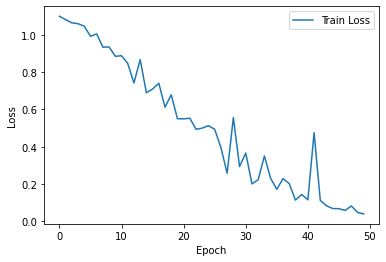

In [232]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.legend()

plot_history()

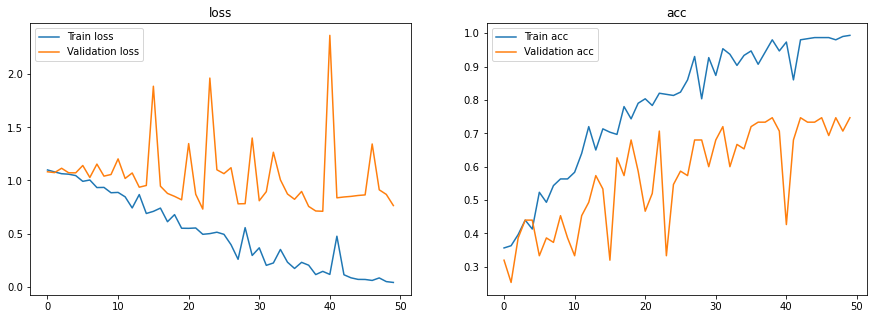

In [233]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

show_final_history(history)

In [234]:
[loss, crossent] = model.evaluate(Xtest_std, ytest)
print('Loss on test set: {}'.format(round(loss, 3)))
y_pred_real = model.predict(Xtest_std)
y_pred = np.argmax(y_pred_real, axis=-1)


ytest_for_report = np.argmax(ytest, axis=-1)
cr = classification_report(ytest_for_report,y_pred)
print(cr)
f1 = f1_score(ytest_for_report, y_pred,average='weighted')
cm = confusion_matrix(ytest_for_report, y_pred)
print(cm)

print("Training matthews_corrcoef")
matthews_corrcoef(ytest_for_report, y_pred)

162/162 [==============================] - 2s 11ms/step
Loss on test set: 0.799
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        54
           1       0.79      0.61      0.69        54
           2       0.72      0.80      0.75        54

    accuracy                           0.78       162
   macro avg       0.78      0.78      0.77       162
weighted avg       0.78      0.78      0.77       162

[[50  2  2]
 [ 6 33 15]
 [ 4  7 43]]
Training matthews_corrcoef


0.6708203932499369

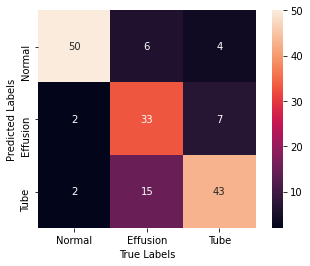

In [235]:
# Confusion matrix for cnn
mat = confusion_matrix(ytest_for_report, y_pred)

class_labels = ["Normal", "Effusion", "Tube"]

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [ ]:
## EXPERIMENT - NOT IN USE FROM HERE

import tensorflow as tf
from tensorflow import keras
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import optimizers
from keras.optimizers import Adam


# X shape:  (454, 228, 200, 3)


def build_MobileNetV2_adapt():
    # set the shape to the CIFAR-10 image size and the number of classes
    input_shape = (228, 200, 3)
    # resize image with padding give better results on the overall performance
    # new_shape = (96, 96, 3)
    classes = 3

    # Create new model on top
    inputs = keras.Input(shape=input_shape)

    # Preprocessing the image
    # x = preprocess_input(inputs)
    # upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(
    #     x, 96, 96, method=tf.image.ResizeMethod.BILINEAR))(inputs)
                                                                  
    # load the VGG16 model with the imagenet weights, but without the final 1000 output layer
    base_model = keras.applications.MobileNetV2(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=input_shape, # input_tensor will be used instead
        input_tensor=inputs,
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model.output#, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    # add a trainable dense layer
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.25)(x)  # Regularize with dropout
    # add a final output layer with a softmax for classification
    outputs = keras.layers.Dense(classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    # make model adaptable
    base_model.trainable = False

    # small learning rate
    # learning_rate = 1e-5

    model.compile(
        optimizer='Adam', #learning_rate=learning_rate
        loss='categorical_crossentropy',
        metrics=['categorical_crossentropy']
    )
    return model

In [ ]:
print(X.shape)
print(y.shape)

(454, 228, 200, 3)
(454,)


In [ ]:
from keras.optimizers import Adam
model = build_MobileNetV2_adapt()
# model.compile(optimizer=Adam(),
#               loss='categorical_crossentropy',
#               metrics=['categorical_accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 228, 200, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 114, 100, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 114, 100, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 114, 100, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# Test with MLP
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

X1 = X[0:400]
y1 = y[0:400]

onehot_encoder = OneHotEncoder(sparse=False)
y_encoded = y1.reshape(len(y1), 1)
y1h = onehot_encoder.fit_transform(y_encoded)

Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1h,test_size=0.33, random_state=42)

# split into train and test
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,stratify=y)
# Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1,test_size=0.33, random_state=42)
model.fit(Xtrain,ytrain)



9/9 [==============================] - 30s 41ms/step - loss: 1.4277 - categorical_crossentropy: 1.4277


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred_real = model.predict(Xtest)
y_pred_max = np.argmax(y_pred_real, axis=-1).astype(int)

y_test_max = ytest.argmax(axis=1).astype(int)

print(y_pred_max)
print(y_test_max)

ac = accuracy_score(y_test_max,y_pred_max)
print('accuracy is {:.2f}%'.format(ac*100)) # Print accuracy score
print()
cr = classification_report(y_test_max,y_pred_max) # Print summary report
print(cr)
cm = confusion_matrix(y_test_max, y_pred_max)
print(cm)
# plot_confusion_matrix(cm)

[1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 2 1 1 1 2 1 1 1 0 0 0 1 0
 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 2 1 1 0 2 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 2 1 1 2 1 0 0 1 1 0
 1 1 1 0 2 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1]
[2 0 0 1 0 0 0 1 2 0 1 1 1 1 0 1 2 0 0 0 0 0 2 2 2 1 2 1 2 1 1 2 0 0 0 1 0
 1 0 0 0 1 0 1 1 0 1 2 2 0 1 0 0 1 0 0 2 1 0 0 2 0 1 1 1 0 1 2 1 1 0 0 1 1
 1 0 2 1 2 0 0 1 1 1 1 2 2 1 1 0 0 1 1 1 0 1 1 1 0 2 0 1 1 0 2 0 1 0 1 2 0
 1 1 0 0 2 2 1 1 1 1 1 2 0 2 0 1 0 2 2 1 2]
accuracy is 62.88%

              precision    recall  f1-score   support

           0       0.79      0.61      0.69        49
           1       0.54      0.85      0.66        55
           2       0.86      0.21      0.34        28

    accuracy                           0.63       132
   macro avg       0.73      0.56      0.56       132
weighted avg       0.70      0.63      0.60       132

[[30 19  0]
 [ 7 47  1]
 [ 1 21  6]]
